<a href="https://colab.research.google.com/github/VedKate/DUDL-course-practice/blob/main/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_%D0%92%D0%B5%D0%B4%D0%B5%D0%BD%D0%B5%D0%B5%D0%B2%D0%B0_%D0%95_%D0%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Данные о датасете (описание, предоставленное вместе с датасетом + перевод)



Сами данные в формате json можно посмореть тут: https://drive.google.com/file/d/1Alkgp5T-srxoAcY63LAi6hNj1pjtlG4G/view?usp=sharing

Датасет предоставлен для решения задачи бинарной классификации (айсберг/корабль) по снимкам со спутника с двумя полосами. 



---



Данные о полях
---


The data (train.json, test.json) is presented in json format.
The files consist of a list of images, and for each image, you can find the following fields:

**id** - the id of the image \
**band_1, band_2** - the flattened image data. Each band has 75x75 pixel values in the list, so the list has 5625 elements

Note that these values are not the normal non-negative integers in image files since they have physical meanings - these are float numbers with unit being dB. \

Band 1 and Band 2 are signals characterized by radar backscatter produced from different polarizations at a particular incidence angle. The polarizations correspond to HH (transmit/receive horizontally) and HV (transmit horizontally and receive vertically). 

**inc_angle** - the incidence angle of which the image was taken. Note that this field has missing data marked as "na", and those images with "na" incidence angles are all in the training data to prevent leakage. \

**is_iceberg** - the target variable, set to 1 if it is an iceberg, and 0 if it is a ship. This field only exists in train.json.\

Please note that we have included machine-generated images in the test set to prevent hand labeling. They are excluded in scoring



**Перевод**

Данные (train.json, test.json) представлены в формате json.
Файлы состоят из списка изображений, и для каждого изображения вы можете найти следующие поля:

**id** - идентификатор изображения 

**band_1, band_2** - данные сглаженного изображения. Каждая полоса имеет значения 75x75 пикселей в списке, таким образом, список содержит 5625 элементов

Обратите внимание, что эти значения не являются обычными неотрицательными целыми числами в файлах изображений, поскольку они имеют физические значения - это числа с плавающей запятой, единицей измерения которых является dB. \

Полоса 1 и полоса 2 (band_1, band_2)- это сигналы, характеризующиеся обратным рассеянием радара, создаваемым при различных поляризациях под определенным углом падения. Поляризации соответствуют HH (передача/прием по горизонтали) и HV (передача по горизонтали и прием по вертикали). 

**inc_angle** - угол падения, под которым было сделано изображение. Обратите внимание, что в этом поле отсутствуют данные, помеченные как "na", и все изображения с углами падения "na" включены в обучающие данные для предотвращения утечки. \

**is_iceberg** - целевая переменная, установленная в 1, если
Меню
Google Переводчик



---



Ниже представлена предобработка данных, в том числе с использованнием метода Матриц совпадения уровней серого (GLCM) (https://towardsdatascience.com/glcms-a-great-tool-for-your-ml-arsenal-7a59f1e45b65) и несколько классических моделей, обученных на этих данных. 

В конце сводка по результатам. 

Импорт библиотек

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
df_train = pd.read_json("/content/drive/MyDrive/8 сместр/практика/train.json")  #/content/drive/MyDrive/8 сместр/практика/train.json
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


In [ ]:
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #конвертирование в float32
        band_1 = np.array(band).astype(np.float32)
        #форматирование band_1
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #конвертирование в float32
        band_2 = np.array(band).astype(np.float32)
        #форматирование band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Конвертирование list в numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Масштабирование
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Соединение band_1 и band_2 для создание объекта X для обучения (или тестирования)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [ ]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


GLCM features and LGBM Image Classification

grayscale_image shape is:(1604, 75, 75)


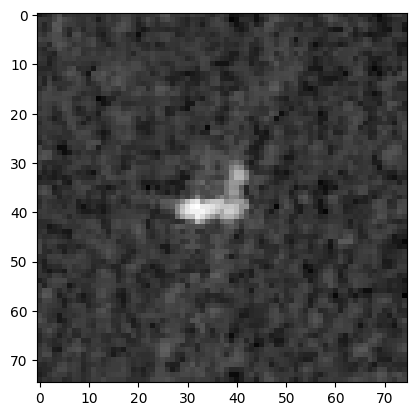

In [ ]:
# Конвертируем изображения в ЧБ для извлечения признаков 
rgb_weights = [0.2989, 0.5870, 0.1140]
images = np.dot(X[...,:3], rgb_weights)
print("grayscale_image shape is:{}".format(images.shape))

# Визуализация
plt.imshow(images[1], cmap=plt.get_cmap("gray"))
plt.show()

In [ ]:
# Примечание: перед тем, как тренировать модель с использованием GLCM, отмасштабируем интенсивность в предетах [0, 1] 
# Затем приведем преобразуем изображение в 8-разрядный целочисленный формат без знака.
bin_width = 32

X_scaled = exposure.rescale_intensity(images, out_range=(0, 1))
X_binned = util.img_as_ubyte(X_scaled)
X_binned = X_binned // bin_width

In [ ]:
X_scaled

array([[[0.1937381 , 0.17183109, 0.14859685, ..., 0.18419204,
         0.1750172 , 0.17721489],
        [0.14859814, 0.12578362, 0.14823006, ..., 0.12441661,
         0.17803488, 0.18286274],
        [0.1219634 , 0.09174614, 0.15617842, ..., 0.14989957,
         0.14000917, 0.14431852],
        ...,
        [0.18013902, 0.1821876 , 0.15061732, ..., 0.20330377,
         0.19963908, 0.18427419],
        [0.15036738, 0.16831984, 0.16924723, ..., 0.17932784,
         0.18699605, 0.12751501],
        [0.15744459, 0.18273541, 0.19345032, ..., 0.16312586,
         0.17753964, 0.17115477]],

       [[0.22295595, 0.24754566, 0.26181664, ..., 0.29192697,
         0.29937485, 0.27675301],
        [0.28324129, 0.28386707, 0.2756642 , ..., 0.26134264,
         0.26265614, 0.27381356],
        [0.28089193, 0.24767817, 0.27940207, ..., 0.27046254,
         0.26855985, 0.22311663],
        ...,
        [0.24430055, 0.25223682, 0.25558604, ..., 0.27005413,
         0.25465068, 0.26753987],
        [0.2

In [ ]:
X_binned

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 0, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 1, 2, ..., 2, 2, 1],
        ...,
        [1, 2, 2, ..., 2, 2, 2],
        [1, 1, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 2]],

       [[1, 1, 2, ..., 2, 1, 1],
        [2, 2, 2, ..., 2, 2, 1],
        [1, 2, 2, ..., 2, 2, 1],
        ...,
        [2, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 2, 2, 1],
        [1, 2, 2, ..., 2, 1, 1]],

       ...,

       [[2, 1, 1, ..., 1, 2, 2],
        [2, 2, 1, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [1, 2, 2, ..., 2, 2, 1]],

       [[1, 2, 2, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 1],
        [1, 1, 1, ..., 2, 2, 1],
        ...,
        [2, 2, 2, ..., 

In [ ]:
SIZE = 75

# Разделетие выборки на тренировочную и тестовую
X_train, X_test, Y_train, Y_test = train_test_split(X_binned, Y, test_size=0.2, random_state=42)

print("X_train shape is:{}".format(X_train.shape))
print("Y_train shape is:{}".format(Y_train.shape))
print("X_test shape is:{}".format(X_test.shape))
print("Y_test shape is:{}".format(Y_test.shape))

X_train shape is:(1283, 75, 75)
Y_train shape is:(1283,)
X_test shape is:(321, 75, 75)
Y_test shape is:(321,)


In [ ]:
def feature_extraction(data):
    img_ds = pd.DataFrame()
    
    
    for img in range(data.shape[0]):
        
        df = pd.DataFrame()
        image = data[img,:,:]
        
      
        # Добавляем данные, используя GLCM
        '''
def graycomatrix(image, distances, angles, levels=None, symmetric=False,
                 normed=False):
    """Calculate the gray-level co-occurrence matrix.
    A gray level co-occurrence matrix is a histogram of co-occurring
    grayscale values at a given offset over an image.
    .. versionchanged:: 0.19
               `greymatrix` was renamed to `graymatrix` in 0.19.
    Parameters
    ----------
    image : array_like
        Integer typed input image. Only positive valued images are supported.
        If type is other than uint8, the argument `levels` needs to be set.
    distances : array_like
        List of pixel pair distance offsets.
    angles : array_like
        List of pixel pair angles in radians.
    levels : int, optional
        The input image should contain integers in [0, `levels`-1],
        where levels indicate the number of gray-levels counted
        (typically 256 for an 8-bit image). This argument is required for
        16-bit images or higher and is typically the maximum of the image.
        As the output matrix is at least `levels` x `levels`, it might
        be preferable to use binning of the input image rather than
        large values for `levels`.
    symmetric : bool, optional
        If True, the output matrix `P[:, :, d, theta]` is symmetric. This
        is accomplished by ignoring the order of value pairs, so both
        (i, j) and (j, i) are accumulated when (i, j) is encountered
        for a given offset. The default is False.
    normed : bool, optional
        If True, normalize each matrix `P[:, :, d, theta]` by dividing
        by the total number of accumulated co-occurrences for the given
        offset. The elements of the resulting matrix sum to 1. The
        default is False.
    Returns
    -------
    P : 4-D ndarray
        The gray-level co-occurrence histogram. The value
        `P[i,j,d,theta]` is the number of times that gray-level `j`
        occurs at a distance `d` and at an angle `theta` from
        gray-level `i`. If `normed` is `False`, the output is of
        type uint32, otherwise it is float64. The dimensions are:
        levels x levels x number of distances x number of angles.

        '''

        GLCM = greycomatrix(image, [1], [0])
        GLCM_energy = greycoprops(GLCM, "energy")[0]
        df["Energy"] = GLCM_energy
        GLCM_corr = greycoprops(GLCM, "correlation")[0]
        df["Correlation"] = GLCM_corr
        GLCM_diss = greycoprops(GLCM, "dissimilarity")[0]
        df["Dissimilarity"] = GLCM_diss
        GLCM_homgen = greycoprops(GLCM, "homogeneity")[0]
        df["Homogenity"] = GLCM_homgen
        GLCM_cont = greycoprops(GLCM, "contrast")[0]
        df["Contrast"] = GLCM_cont
        
        # GLCM 2
        GLCM2 = greycomatrix(image, [3], [0])
        GLCM_energy2 = greycoprops(GLCM2, "energy")[0]
        df["Energy2"] = GLCM_energy2
        GLCM_corr2 = greycoprops(GLCM2, "correlation")[0]
        df["Correlation2"] = GLCM_corr2
        GLCM_diss2 = greycoprops(GLCM2, "dissimilarity")[0]
        df["Dissimilarity2"] = GLCM_diss2
        GLCM_homgen2 = greycoprops(GLCM2, "homogeneity")[0]
        df["Homogeneity2"] = GLCM_homgen2
        GLCM_cont2 = greycoprops(GLCM2, "contrast")[0]
        df["Contrast2"] = GLCM_cont2

        # GLCM 3
        GLCM3 = greycomatrix(image, [5], [0])
        GLCM_energy = greycoprops(GLCM3, "energy")[0]
        df["Energy3"] = GLCM_energy
        GLCM_corr3 = greycoprops(GLCM3, "correlation")[0]
        df["Correlation3"] = GLCM_corr3
        GLCM_diss3 = greycoprops(GLCM3, "dissimilarity")[0]
        df["Dissimilarity3"] = GLCM_diss3
        GLCM_homgen3 = greycoprops(GLCM3, "homogeneity")[0]
        df["Homogeneity3"] = GLCM_homgen3
        GLCM_cont3 = greycoprops(GLCM3, "contrast")[0]
        df["Contrast3"] = GLCM_cont3
        
        # GLCM 4
        GLCM4 = greycomatrix(image, [0], [np.pi/4])
        GLCM_energy4 = greycoprops(GLCM4, "energy")[0]
        df["Energy4"] = GLCM_energy4
        GLCM_corr4 = greycoprops(GLCM4, "correlation")[0]
        df["Correlation4"] = GLCM_corr4
        GLCM_diss4 = greycoprops(GLCM4, "dissimilarity")[0]
        df["Dissimilarity4"] = GLCM_diss4
        GLCM_homgen4 = greycoprops(GLCM4, "homogeneity")[0]
        df["Homogeneity4"] = GLCM_homgen4
        GLCM_cont4 = greycoprops(GLCM4, "contrast")[0]
        df["Contrast4"] = GLCM_cont4
        
        # GLCM 5
        GLCM5 = greycomatrix(image, [0], [np.pi/8])
        GLCM_energy5 = greycoprops(GLCM5, "energy")[0]
        df["Energy5"] = GLCM_energy5
        GLCM_corr5 = greycoprops(GLCM5, "correlation")[0]
        df["Correlation5"] = GLCM_corr5
        GLCM_diss5 = greycoprops(GLCM5, "dissimilarity")[0]
        df["Dissimilarity5"] = GLCM_diss5
        GLCM_homgen5 = greycoprops(GLCM5, "homogeneity")[0]
        df["Homogeneity5"] = GLCM_homgen5
        GLCM_cont5 = greycoprops(GLCM5, "contrast")[0]
        df["Contrast5"] = GLCM_cont5
        
        # Помещаем признаки в img_ds
        img_ds = img_ds.append(df)
        
    return img_ds

In [ ]:
# Выделяем признаки из X_train
img_features = feature_extraction(X_train)
X_for_training = img_features

# Выделяем признаки из X_test
img_test_features = feature_extraction(X_test)
img_test_features = np.expand_dims(img_test_features, axis=0)
X_for_test = np.reshape(img_test_features, (X_test.shape[0], -1))

Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  r

In [ ]:
print("Image Features shape is = {}".format(img_features.shape))

Image Features shape is = (1283, 25)


In [ ]:
X_for_training

,Energy,Correlation,Dissimilarity,Homogenity,Contrast,Energy2,Correlation2,Dissimilarity2,Homogeneity2,Contrast2,...,Energy4,Correlation4,Dissimilarity4,Homogeneity4,Contrast4,Energy5,Correlation5,Dissimilarity5,Homogeneity5,Contrast5
0,0.813230,0.542161,0.124505,0.937820,0.125225,0.784742,0.239189,0.196667,0.902481,0.204815,...,0.874778,1.0,0.0,1.0,0.0,0.874778,1.0,0.0,1.0,0.0
0,0.794441,0.419228,0.145405,0.927297,0.145405,0.758813,0.050256,0.235926,0.882185,0.237407,...,0.868847,1.0,0.0,1.0,0.0,0.868847,1.0,0.0,1.0,0.0
0,0.807430,0.699665,0.133153,0.933423,0.133153,0.783904,0.472729,0.209444,0.897722,0.233889,...,0.867860,1.0,0.0,1.0,0.0,0.867860,1.0,0.0,1.0,0.0
0,0.575866,0.372895,0.307748,0.846126,0.307748,0.544232,0.113206,0.436111,0.781944,0.436111,...,0.735102,1.0,0.0,1.0,0.0,0.735102,1.0,0.0,1.0,0.0
0,0.590769,0.598011,0.240180,0.879910,0.240180,0.539493,0.308572,0.402222,0.800333,0.416667,...,0.722245,1.0,0.0,1.0,0.0,0.722245,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.606259,0.322731,0.290631,0.854685,0.290631,0.570866,-0.005088,0.433148,0.783426,0.433148,...,0.757281,1.0,0.0,1.0,0.0,0.757281,1.0,0.0,1.0,0.0
0,0.547784,0.367584,0.312613,0.843694,0.312613,0.514276,0.026101,0.480741,0.759704,0.481481,...,0.717074,1.0,0.0,1.0,0.0,0.717074,1.0,0.0,1.0,0.0
0,0.646054,0.424185,0.239640,0.880180,0.239640,0.599405,0.030036,0.400185,0.800315,0.404259,...,0.773748,1.0,0.0,1.0,0.0,0.773748,1.0,0.0,1.0,0.0
0,0.974306,0.307701,0.021081,0.989459,0.021081,0.971393,0.121230,0.026852,0.986574,0.026852,...,0.984770,1.0,0.0,1.0,0.0,0.984770,1.0,0.0,1.0,0.0


LGBM модель

In [ ]:
# Примечание: в модели LGBM номер классов будет начинаться с 0, по этой причине здесь мы переназначаем метки с 1,2,3,4 на 0,1,2,3 и т.д.
dtrain = lgb.Dataset(X_for_training, label = Y_train)


# Установка параметров lgbm
# Примечание: здесь мы имеем дело с задачей бинарной классификации, поэтому "target" должна быть "binary"
lgbm_parameters = {"learning_rate":1.0,
                   "task":"train",
                   "boosting_type":"gbdt",
                   "objective":"binary",
                   "num_leaves":63,
                   "min_data_in_leaf":1,
                   "feature_fraction":1.0,
                   "bagging_freq":50,  
                   "bagging_fraction":0.8,
                   "max_depth":5,
                   "num_class":1}

In [ ]:
# Сборка модели LGBM
lgbm_model = lgb.train(lgbm_parameters, dtrain, 100)

[LightGBM] [Info] Number of positive: 589, number of negative: 694
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.111000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 1283, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.459080 -> initscore=-0.164046
[LightGBM] [Info] Start training from score -0.164046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [ ]:
# Предсказание
prediction = lgbm_model.predict(X_for_test)
#prediction = np.argmax(prediction, axis=1)

In [ ]:
# Проверка параметра accuracy

# Примечание: значение предсказания - это вероятность (числа с плавающей запятой), однако Y_test - это целочисленные значения,
# поэтому нам нужно округлить () предсказание до целых единиц
acc = accuracy_score(prediction.round(), Y_test)
print("Accuracy = {}".format(acc))

Accuracy = 0.6853582554517134


<Axes: >

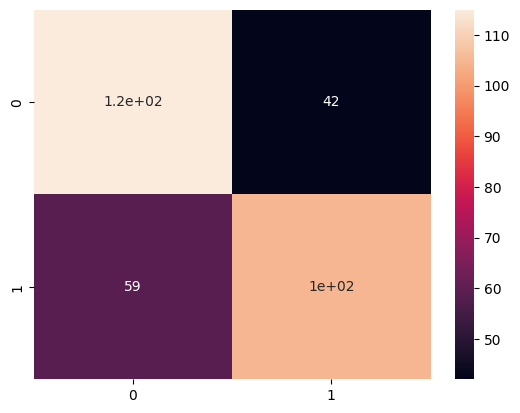

In [ ]:
# Матрица ошибок
cm = confusion_matrix(Y_test, prediction.round())
sns.heatmap(cm, annot=True)

In [ ]:
print(classification_report(Y_test, prediction.round()))

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       157
           1       0.71      0.64      0.68       164

    accuracy                           0.69       321
   macro avg       0.69      0.69      0.69       321
weighted avg       0.69      0.69      0.68       321



/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

The prediction for this image is:  0
The actual label for this image is:  0


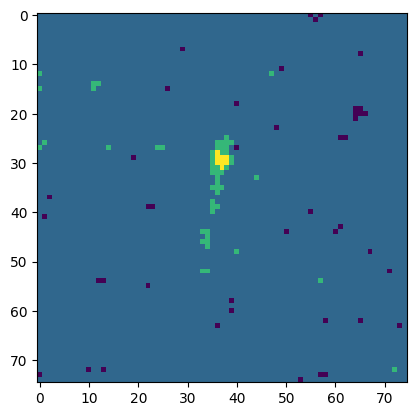

In [ ]:
#Проверим результаты на отдельных изображениях
num = np.random.randint(0, X_test.shape[0]-1)
img = X_test[num]
plt.imshow(img)

# Преобразование входных данных в формат (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature=feature_extraction(input_img)
img_feature = np.expand_dims(img_feature, axis=0)
input_img_for_lgbm = np.reshape(img_feature, (input_img.shape[0], -1))

#Предсказание
y_pred = lgbm_model.predict(input_img_for_lgbm)
y_pred = np.argmax(y_pred, axis=0) 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimag

The prediction for this image is:  0
The actual label for this image is:  0


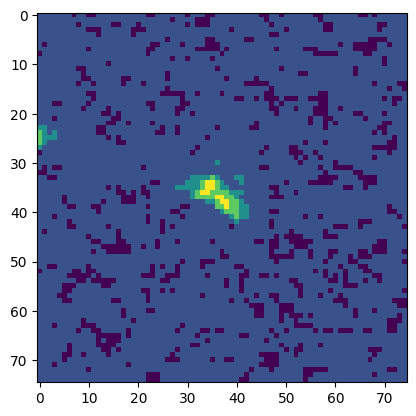

In [ ]:
#Еще один пример
num = np.random.randint(0, X_test.shape[0]-1)
img = X_test[num]
plt.imshow(img)


input_img = np.expand_dims(img, axis=0) 
img_feature=feature_extraction(input_img)
img_feature = np.expand_dims(img_feature, axis=0)
input_img_for_lgbm = np.reshape(img_feature, (input_img.shape[0], -1))


y_pred = lgbm_model.predict(input_img_for_lgbm)
y_pred = np.argmax(y_pred, axis=0) 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

Модель случайного леса

In [ ]:
RF_model = RandomForestClassifier(n_estimators=50, random_state=42)
RF_model.fit(X_for_training, Y_train)
print("Fitting the RF model")

Fitting the RF model


In [ ]:
# Предсказание
y_pred = RF_model.predict(X_for_test)

# Вычисление accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.7507788161993769


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Важность признаков
print(RF_model.feature_importances_)

[0.04737892 0.09534453 0.04929591 0.05459773 0.04783762 0.04414976
 0.09292765 0.04248083 0.04493914 0.05923804 0.05169776 0.10473655
 0.04090861 0.03656332 0.08464924 0.05179698 0.         0.
 0.         0.         0.05145741 0.         0.         0.
 0.        ]


Модель на основе машины опорных векторов

In [ ]:
C = 1.0
SVM_model = svm.SVC(kernel="rbf", C=C).fit(X_for_training, Y_train)
print("Training SVM model")

Training SVM model


In [ ]:
# Предсказаие
y_pred_svm = SVM_model.predict(X_for_test)

# Вычисление accuracy
accuracy = accuracy_score(Y_test, y_pred_svm)
print("Accuracy = {}".format(accuracy))

Accuracy = 0.5794392523364486


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Результаты тренировки моделей

In [ ]:
models = ["LGBM model", "Random Forest model", "SVM model"]

accuracy = [67, 75, 57]
dic = {"Models":models, "Accuracy":accuracy}

df_models = pd.DataFrame.from_dict(dic, orient='index')
df_models.transpose()

,Models,Accuracy
0,LGBM model,67
1,Random Forest model,75
2,SVM model,57
